# Proyek Klasifikasi Gambar: [Flowers Recognition-Alexander Mamaev]
- **Nama:** [TRI RAMDHANY]
- **Email:** [triramdhany@gmail.com]

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
from tqdm.notebook import tqdm as tq
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input, Rescaling
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 37.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [3]:
!kaggle datasets download -d alxmamaev/flowers-recognition

Dataset URL: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition
License(s): unknown
100% 225M/225M [00:13<00:00, 19.8MB/s]
100% 225M/225M [00:13<00:00, 18.0MB/s]


In [4]:
!unzip flowers-recognition.zip

Archive:  flowers-recognition.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  i

In [5]:
#Combined Direktori
combined_dir = 'flowers_recog/dataset'

In [6]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [7]:
base_dir = '/content/flowers'
print(os.listdir(base_dir))

['daisy', 'dandelion', 'rose', 'tulip', 'sunflower']


In [8]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 4317


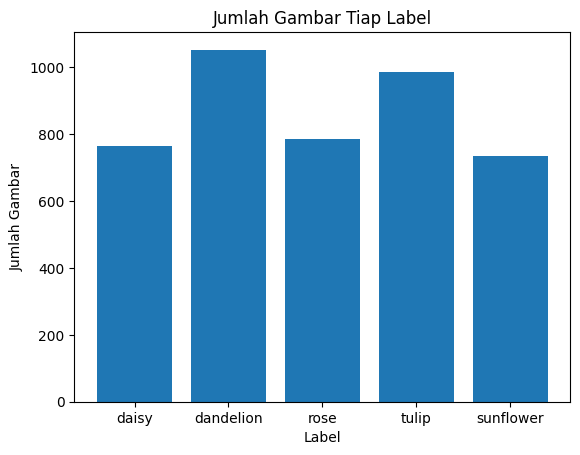

In [9]:
plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

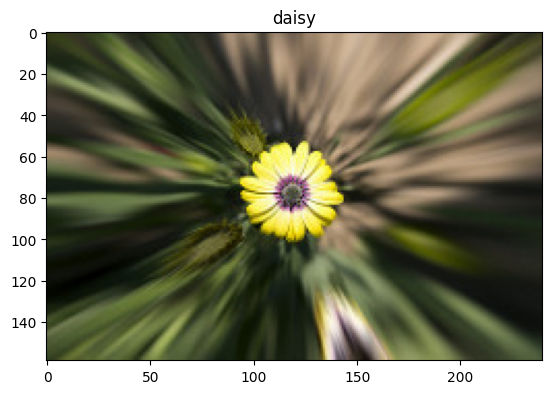

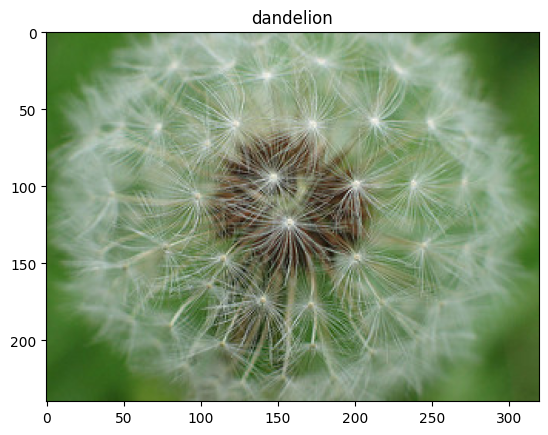

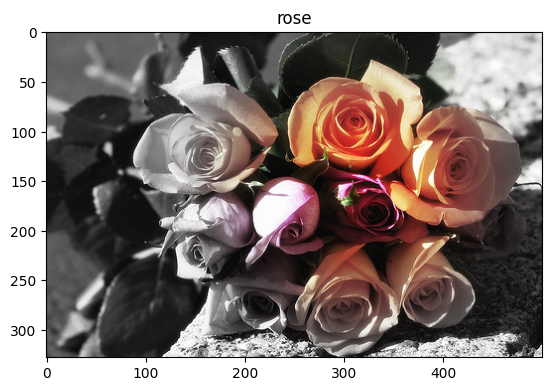

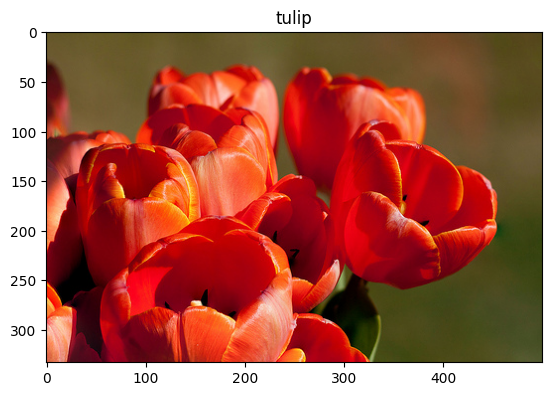

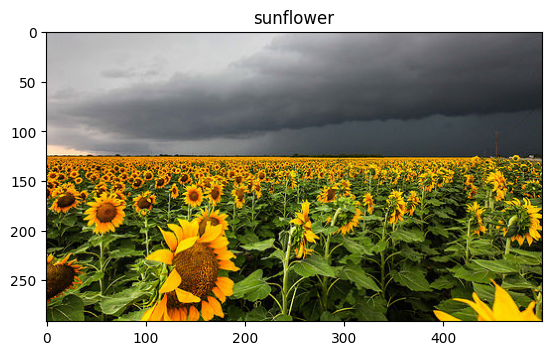

In [10]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

# Data Augmentation

In [11]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (256,256))
  sudut = random.randint(0, 180)
  return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (256,256))
  sudut = random.randint(0, 180)
  return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (256,256))
  return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (256,256))
  img = adjust_gamma(img, gamma=0.5, gain=1)
  return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (256,256))
  return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (256,256))
  transform = AffineTransform(shear=0.2)
  shear_image = warp(img, transform, mode='wrap')
  return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
  img = cv2.cvtColor(img, 0)
  img = cv2.resize(img, (256,256))
  transform = AffineTransform(translation=(0,40))
  warp_image = warp(img, transform, mode="wrap")
  return warp_image

In [12]:
# Membuat variabel transformasi yang akan menyimpan semua proses pra-pemrosesan yang telah dilakukan sebelumnya
transformations = {'rotate anticlockwise' : anticlockwise_rotation,
                  'rotate clockwise' : clockwise_rotation,
                  'flip up down' : flip_up_down,
                  'add brigthness' : add_brightness,
                  'blurring image' : blur_image,
                  'sheared image' : sheared,
                  'warp shift' : warp_shift}

dataset_dirs = ['flowers/daisy', 'flowers/dandelion', 'flowers/rose','flowers/sunflower','flowers/tulip']

# Loop untuk menerapkan augmentasi ke masing-masing dataset
for dataset_dir in dataset_dirs:
    images = []

    # Baca nama gambar dari folder dan tambahkan path ke dalam array "images"
    for im in os.listdir(dataset_dir):
        images.append(os.path.join(dataset_dir, im))

    images_to_generate = 250
    i = 1

    while i <= images_to_generate:
        image = random.choice(images)
        try:
            original_image = io.imread(image)
            transformed_image = None
            n = 0  # Variabel untuk melakukan iterasi sampai jumlah transformasi yang akan diterapkan
            transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak yang akan diterapkan pada gambar

            while n < transformation_count:
                key = random.choice(list(transformations))  # Secara acak memilih dan memanggil metode
                transformed_image = transformations[key](original_image)
                n += 1

            new_image_path = os.path.join(dataset_dir, f"augmented_image_{i}.jpg")
            transformed_image = img_as_ubyte(transformed_image)  # Konversi gambar ke format byte
            cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil transformasi augmentasi pada gambar ke path yang ditentukan
            i += 1
        except ValueError as e:
            print('Could not read the', image, ':', e, 'hence skipping it.')

print("Augmentasi selesai!")

Augmentasi selesai!


## Data Spliting

In [13]:
mypath = 'flowers'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
  for name in files:
    full_path.append(os.path.join(path, name))
    labels.append(path.split('/')[-1])
    file_name.append(name)

df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
daisy,1014
dandelion,1302
rose,1034
sunflower,983
tulip,1234


In [14]:
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels
X = df['path']
y = df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=300)


In [15]:
#Menyatukan dataframe
df_tr = pd.DataFrame({'path':X_train, 'labels':y_train, 'set':'train'})
df_te = pd.DataFrame({'path':X_test, 'labels':y_test, 'set':'test'})

In [16]:
#Gabungkan DataFrame
df_all = pd.concat([df_tr,df_te], ignore_index=True)

In [17]:
df_all.head()

,path,labels,set
0,flowers/tulip/4042180234_64cd2859c9_m.jpg,tulip,train
1,flowers/daisy/5924910021_b6debeb7b5_n.jpg,daisy,train
2,flowers/daisy/34696729796_190b1dfdf1_n.jpg,daisy,train
3,flowers/tulip/3454461550_64d6e726bf_m.jpg,tulip,train
4,flowers/tulip/17844723633_da85357fe3.jpg,tulip,train


In [18]:
print(df_all.groupby(['set','labels']).size(), '\n')

set    labels   
test   daisy         205
       dandelion     265
       rose          214
       sunflower     189
       tulip         241
train  daisy         809
       dandelion    1037
       rose          820
       sunflower     794
       tulip         993
dtype: int64 



In [19]:
#Memanggil data asli
datasource_path = 'flowers'

# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = 'flowers_recog/dataset'

In [20]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

# Image Data Generator


In [21]:

#Definisikan TRAIN_DIR dan TEST_DIR
TRAIN_DIR = 'flowers_recog/dataset/train'
TEST_DIR = 'flowers_recog/dataset/test'

train_daisy = os.path.join(TRAIN_DIR, 'daisy')
train_dandelion = os.path.join(TRAIN_DIR, 'dandelion')
train_rose = os.path.join(TRAIN_DIR, 'rose')
train_sunflower = os.path.join(TRAIN_DIR, 'sunflower')
train_tulip = os.path.join(TRAIN_DIR, 'tulip')

test_daisy = os.path.join(TEST_DIR, 'daisy')
test_dandelion = os.path.join(TEST_DIR, 'dandelion')
test_rose = os.path.join(TEST_DIR, 'rose')
test_sunflower = os.path.join(TEST_DIR, 'sunflower')
test_tulip = os.path.join(TEST_DIR, 'tulip')

train = [train_daisy, train_dandelion, train_rose, train_sunflower,train_tulip]
test = [test_daisy,test_dandelion,test_rose,test_sunflower,test_tulip]

for i in train:
    print(f'Total number of {i} images in training set', len(os.listdir(i)))

for i in test:
    print(f'Total number of {i} images in test set' ,len(os.listdir(i)))

Total number of flowers_recog/dataset/train/daisy images in training set 809
Total number of flowers_recog/dataset/train/dandelion images in training set 1037
Total number of flowers_recog/dataset/train/rose images in training set 820
Total number of flowers_recog/dataset/train/sunflower images in training set 794
Total number of flowers_recog/dataset/train/tulip images in training set 993
Total number of flowers_recog/dataset/test/daisy images in test set 205
Total number of flowers_recog/dataset/test/dandelion images in test set 265
Total number of flowers_recog/dataset/test/rose images in test set 214
Total number of flowers_recog/dataset/test/sunflower images in test set 189
Total number of flowers_recog/dataset/test/tulip images in test set 241


In [22]:
datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(224, 224),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)


test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=32,
                                                  target_size=(224, 224),
                                                  color_mode='rgb',
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 4453 images belonging to 5 classes.
Found 1114 images belonging to 5 classes.


#MODEL 1 CNN

In [23]:
tf.keras.backend.clear_session(),
model1 = Sequential([
    Input(shape=(224, 224, 3), batch_size=32),

    Rescaling(1./255.),
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', name='Conv2D_1'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Conv2D_2'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv2D_3'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='Conv2D_4'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.5),

    Flatten(),
    Dense(units=32, activation='relu'),
    BatchNormalization(),
    Dense(units=64, activation='relu'),
    BatchNormalization(),
    Dense(units=128, activation='relu'),
    BatchNormalization(),
    Dense(units=5, activation='softmax')

])
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (32, 224, 224, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_1 (Conv2D)                    │ (32, 222, 222, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (32, 222, 222, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 111, 111, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (Conv2D)                    │ (32, 109, 109, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (32, 109, 109, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 54, 54, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3 (Conv2D)                    │ (32, 52, 52, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (32, 52, 52, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 26, 26, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_4 (Conv2D)                    │ (32, 24, 24, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (32, 24, 24, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 12, 12, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 12, 12, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 18432)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 32)                    │         589,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (32, 32)                    │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 64)                    │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (32, 64)                    │             2

 Total params: 700,229 (2.67 MB)

 Trainable params: 699,301 (2.67 MB)

 Non-trainable params: 928 (3.62 KB)

In [24]:
#Callbacks
ES = EarlyStopping(monitor='val_accuracy', patience=10, verbose=2, restore_best_weights=True, mode='max', min_delta=0)
MP = ModelCheckpoint(filepath='Best_model1.keras', monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
RP = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, min_lr=0.0001, factor=0.2)

In [25]:
# Save the model
model1.save('flowers_reconition1.h5')

# Save model architecture and weights to JSON format
model_json = model1.to_json()
with open("flowers_reconition1.json", "w") as json_file:
    json_file.write(model_json)

model1.save_weights("flowers_reconition1.weights.h5")

In [26]:
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=[ES, MP, RP])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.4028 - loss: 1.5400
Epoch 1: val_accuracy improved from -inf to 0.23788, saving model to Best_model1.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 35s 156ms/step - accuracy: 0.4037 - loss: 1.5375 - val_accuracy: 0.2379 - val_loss: 2.5264 - learning_rate: 0.0010
Epoch 2/20
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5644 - loss: 1.0705
Epoch 2: val_accuracy did not improve from 0.23788
140/140 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.5646 - loss: 1.0702 - val_accuracy: 0.2379 - val_loss: 2.5242 - learning_rate: 0.0010
Epoch 3/20
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6313 - loss: 0.9589
Epoch 3: val_accuracy did not improve from 0.23788
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.6314 - loss: 0.9585 - val_accuracy: 0.2379 - val_loss: 2.2114 - learning_rate: 0.0010
Epoch 4/20
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6811 - loss: 0.8166
Epoch 4: val_accuracy improved from 0.23788

#EVALUASI MODEL 1 CNN

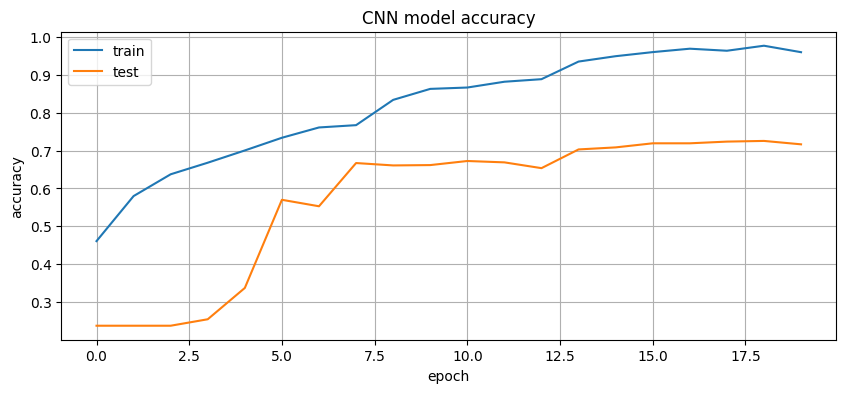

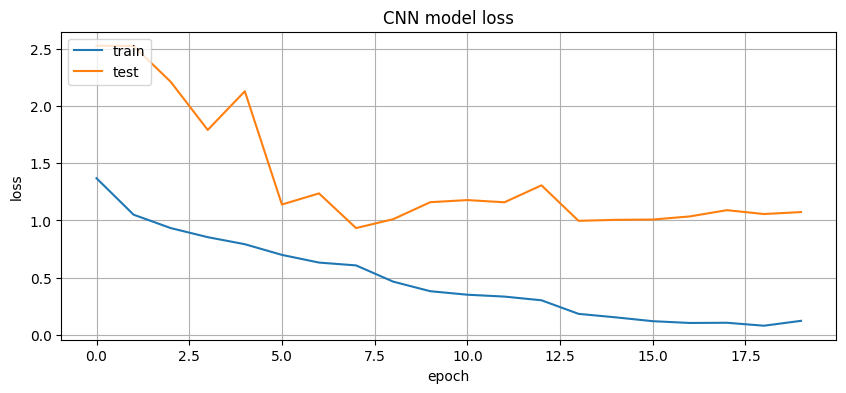

In [27]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step


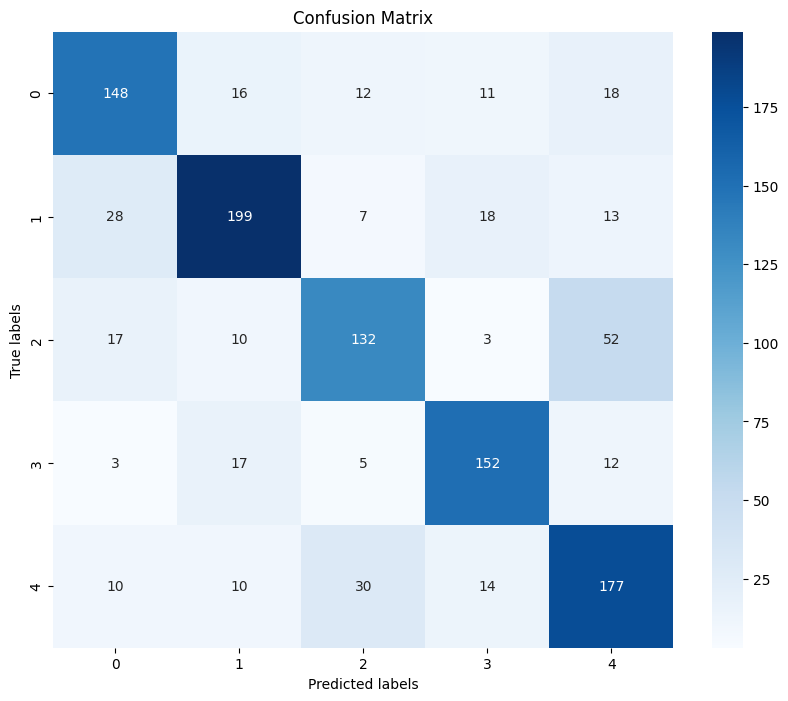

              precision    recall  f1-score   support

           0       0.72      0.72      0.72       205
           1       0.79      0.75      0.77       265
           2       0.71      0.62      0.66       214
           3       0.77      0.80      0.79       189
           4       0.65      0.73      0.69       241

    accuracy                           0.73      1114
   macro avg       0.73      0.73      0.73      1114
weighted avg       0.73      0.73      0.73      1114



In [28]:
# Mendapatkan prediksi dari model
Y_pred = model1.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Mendapatkan label sebenarnya dari test generator
y_true = test_generator.classes

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix menggunakan seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan classification report
print(classification_report(y_true, y_pred))

#MODEL 2 TRANSFER LEARNING MOBILENETV2

In [29]:
tf.keras.backend.clear_session(),
model2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
model2.trainable = False

# Add custom layers on top of the base model
x = model2.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)
model2.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [30]:
#Callbacks
ES = EarlyStopping(monitor='val_accuracy', patience=10, verbose=2, restore_best_weights=True, mode='max', min_delta=0)
MP = ModelCheckpoint(filepath='Best_model2.keras', monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
RP = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, min_lr=0.0001, factor=0.2)

In [31]:
# Save the model
model2.save('flowers_reconition2.h5')

# Save model architecture and weights to JSON format
model_json = model2.to_json()
with open("flowers_reconition2.json", "w") as json_file:
    json_file.write(model_json)

model2.save_weights("flowers_reconition2.weights.h5")

In [32]:
model2 = Model(inputs=model2.input, outputs=predictions)

In [33]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(train_generator, validation_data=test_generator, epochs=20, callbacks=[ES, MP, RP])

Epoch 1/20
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.7027 - loss: 0.8294
Epoch 1: val_accuracy improved from -inf to 0.85458, saving model to Best_model2.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 44s 192ms/step - accuracy: 0.7040 - loss: 0.8258 - val_accuracy: 0.8546 - val_loss: 0.4246 - learning_rate: 0.0010
Epoch 2/20
139/140 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9010 - loss: 0.2851
Epoch 2: val_accuracy improved from 0.85458 to 0.86176, saving model to Best_model2.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 19s 103ms/step - accuracy: 0.9010 - loss: 0.2850 - val_accuracy: 0.8618 - val_loss: 0.3981 - learning_rate: 0.0010
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9479 - loss: 0.1652
Epoch 3: val_accuracy improved from 0.86176 to 0.87433, saving model to Best_model2.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.9479 - loss: 0.1652 - val_accuracy: 0.8743 - val_loss: 0.3891 - learning_rate: 0.0010
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━

#EVALUASI MODEL 2 TRANSFER LEARNING MOBILENETV2

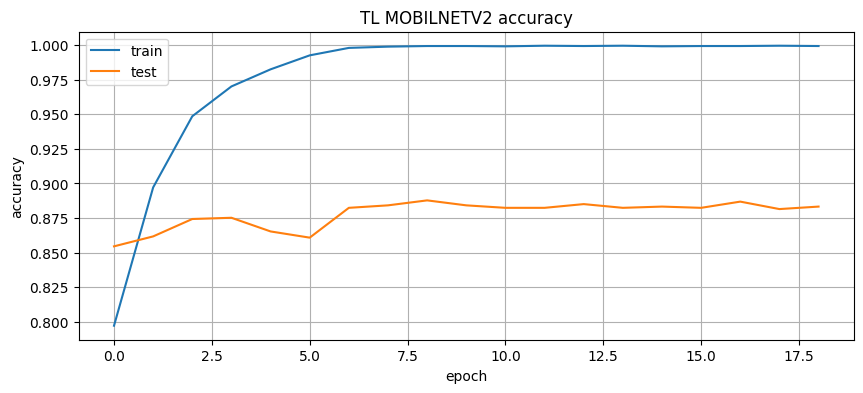

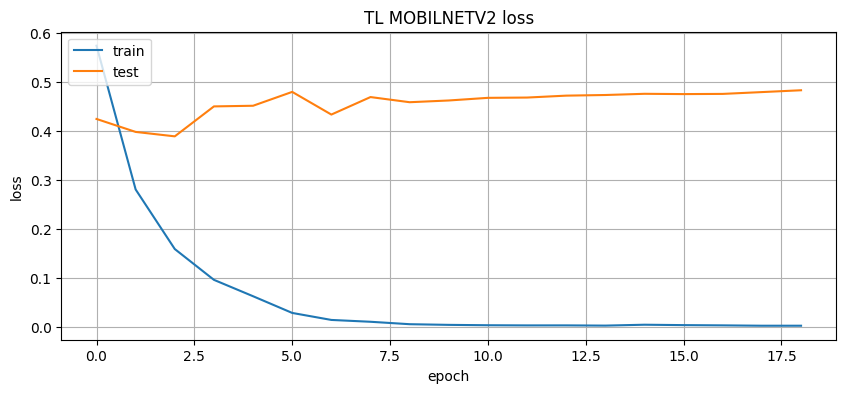

In [34]:
# Membuat plot akurasi model mobilnetv2
plt.figure(figsize=(10,4))
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('TL MOBILNETV2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model mobilenetv2
plt.figure(figsize=(10,4))
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('TL MOBILNETV2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step


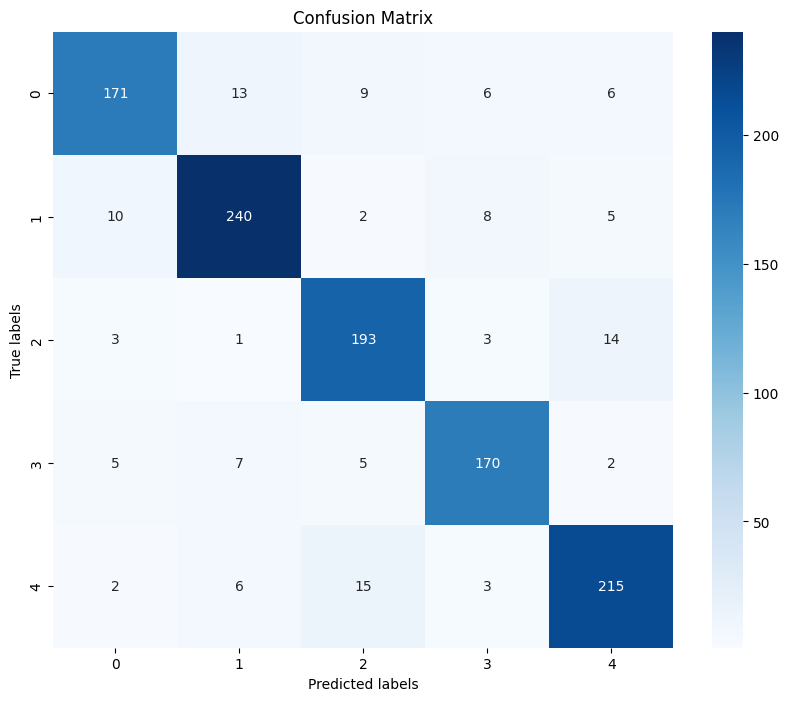

              precision    recall  f1-score   support

           0       0.90      0.83      0.86       205
           1       0.90      0.91      0.90       265
           2       0.86      0.90      0.88       214
           3       0.89      0.90      0.90       189
           4       0.89      0.89      0.89       241

    accuracy                           0.89      1114
   macro avg       0.89      0.89      0.89      1114
weighted avg       0.89      0.89      0.89      1114



In [35]:
# Mendapatkan prediksi dari model
Y_pred = model2.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Mendapatkan label sebenarnya dari test generator
y_true = test_generator.classes

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix menggunakan seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan classification report
print(classification_report(y_true, y_pred))


# Uji coba Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


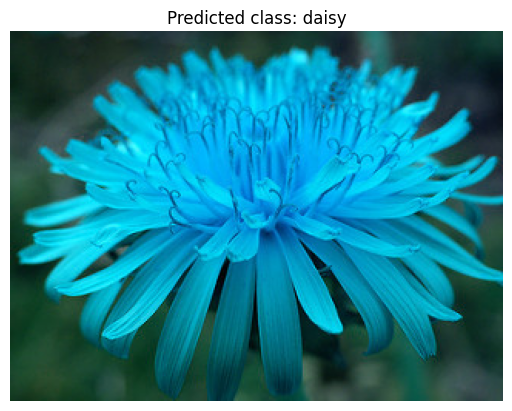

In [42]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import cv2
best_model = load_model('Best_model2.keras')

# Function to make predictions
def predict_image(image_path):
  img = load_img(image_path, target_size=(224, 224))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0  # Normalize the image

  prediction = best_model.predict(img_array)
  predicted_class = np.argmax(prediction)

  class_labels = ['sunflower', 'daisy', 'dandelion', 'tulip', 'rose']
  predicted_label = class_labels[predicted_class]

  return predicted_label

# Example usage
image_path = '/content/images2.jpg'
prediction = predict_image(image_path)
image_path = cv2.imread(image_path)
plt.imshow(image_path)
plt.title(f"Predicted class: {prediction}")
plt.axis('off')
plt.show()


# Konversi Model

###SAVE MODEL

In [43]:
save_path = 'saved_model/'
tf.saved_model.save(model2, save_path)

###TFLite

In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()
with tf.io.gfile.GFile('triramdhany-model-flowers-recognition.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmp24n0v1i5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  137511446274192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137511455322560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137511455316576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137511446278416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137511446280880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137511455318160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137511455317104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137511455322912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137511455310944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137511455311472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13751145531024

###TFJS

In [52]:
model2.save('model2.h5')

In [55]:
!tensorflowjs_converter --input_format=keras flowers_reconition2.h5' tfjs_model

/bin/bash: -c: line 1: unexpected EOF while looking for matching `''
/bin/bash: -c: line 2: syntax error: unexpected end of file


In [54]:
!tensorflowjs_converter --input_format keras \
                       path/to/model.h5 \
                       path/to/tfjs_target_dir

2024-09-06 16:38:05.732278: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-06 16:38:05.752037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-06 16:38:05.757822: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-06 16:38:06.829742: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    

In [56]:
!pip freeze > requirements.txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')